In [1]:
from datetime import date
import pandas as pd
import numpy as np
import urllib
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.distributions as dist
from argparse import ArgumentParser
from torch.utils.tensorboard import SummaryWriter
import time
import random, tqdm, sys, math, gzip
import matplotlib.pyplot as plt

In [2]:
daterange = pd.date_range("3/15/20", "9/04/20")

In [3]:
cases_world = pd.read_csv("/workspace/COVID-19/new_cases.csv")

new_cases_usa = cases_world.iloc[75:249]["United States"]

deaths_world = pd.read_csv("/workspace/COVID-19/new_deaths.csv")

new_deaths_usa = deaths_world.iloc[75:249]["United States"]

In [193]:
from torch import Tensor
import torch.nn.functional as f


def scaled_dot_product_attention(query: Tensor, key: Tensor, value: Tensor) -> Tensor:
    temp = torch.matmul(query.transpose(0,1), key)
    scale = query.size(-1) ** 0.5
    softmax = f.softmax(temp / scale, dim=-1)
    return torch.matmul(softmax, value.transpose(0,1)).transpose(0,1)

import torch
from torch import nn


class AttentionHead(nn.Module):
    def __init__(self, dim_in: int, dim_k: int, dim_v: int):
        super().__init__()
        self.q = nn.Linear(dim_in, dim_k)
        self.k = nn.Linear(dim_in, dim_k)
        self.v = nn.Linear(dim_in, dim_v)

    def forward(self, query: Tensor, key: Tensor, value: Tensor) -> Tensor:
        return scaled_dot_product_attention(self.q(query), self.k(key), self.v(value))
    
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads: int, dim_in: int, dim_k: int, dim_v: int):
        super().__init__()
        self.heads = nn.ModuleList(
            [AttentionHead(dim_in, dim_k, dim_v) for _ in range(num_heads)]
        )
        self.linear = nn.Linear(num_heads * dim_v, dim_in)

    def forward(self, query: Tensor, key: Tensor, value: Tensor) -> Tensor:
        return self.linear(
            torch.cat([h(query, key, value) for h in self.heads], dim=-1)
        )
    
def position_encoding(seq_len: int, dim_model: int, device: torch.device = torch.device("cpu"),) -> Tensor:
    pos = torch.arange(seq_len, dtype=torch.long, device=device).reshape(-1, 1)
    dim = torch.arange(dim_model, dtype=torch.long, device=device).reshape(1, -1)
    phase = (pos / 1e4) ** (dim // dim_model)

    return torch.where(dim.long() % 2 == 0, torch.sin(phase), torch.cos(phase))

def feed_forward(dim_input: int = 4, dim_feedforward: int = 4) -> nn.Module:
    return nn.Sequential(
        nn.Linear(dim_input, dim_feedforward),
        nn.ReLU(),
        nn.Linear(dim_feedforward, dim_input),
    )

class Residual(nn.Module):
    def __init__(self, sublayer: nn.Module, dimension: int, dropout: float = 0.1):
        super().__init__()
        self.sublayer = sublayer
        self.norm = nn.LayerNorm(dimension)
        self.dropout = nn.Dropout(dropout)

    def forward(self, *tensors: Tensor) -> Tensor:
        # Assume that the "value" tensor is given last, so we can compute the
        # residual.  This matches the signature of 'MultiHeadAttention'.
        return self.norm(tensors[-1] + self.dropout(self.sublayer(*tensors)))
    
class TransformerEncoderLayer(nn.Module):
    def __init__(
        self, 
        dim_model: int = 3, 
        num_heads: int = 2, 
        dim_feedforward: int = 4, 
        dropout: float = 0.1, 
    ):
        super().__init__()
        dim_k = dim_v = dim_model // num_heads
        self.attention = Residual(
            MultiHeadAttention(num_heads, dim_model, dim_k, dim_v),
            dimension=dim_model,
            dropout=dropout,
        )
        self.feed_forward = Residual(
            feed_forward(dim_model, dim_feedforward),
            dimension=dim_model,
            dropout=dropout,
        )

    def forward(self, src: Tensor) -> Tensor:
        src = self.attention(src, src, src)
        return self.feed_forward(src)


class TransformerEncoder(nn.Module):
    def __init__(
        self, 
        num_layers: int = 4,
        dim_model: int = 3, 
        num_heads: int = 2, 
        dim_feedforward: int = 4, 
        dropout: float = 0.1, 
    ):
        super().__init__()
        
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(dim_model, num_heads, dim_feedforward, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, src: Tensor) -> Tensor:
        seq_len, dimension = src.size(0), src.size(1)
        src = src + position_encoding(seq_len, dimension)
        for layer in self.layers:
            src = layer(src)

        return src
    
class TransformerDecoderLayer(nn.Module):
    def __init__(
        self, 
        dim_model: int = 3, 
        num_heads: int = 2, 
        dim_feedforward: int = 4, 
        dropout: float = 0.1, 
    ):
        super().__init__()
        dim_k = dim_v = dim_model // num_heads
        self.attention_1 = Residual(
            MultiHeadAttention(num_heads, dim_model, dim_k, dim_v),
            dimension=dim_model,
            dropout=dropout,
        )
        self.attention_2 = Residual(
            MultiHeadAttention(num_heads, dim_model, dim_k, dim_v),
            dimension=dim_model,
            dropout=dropout,
        )
        self.feed_forward = Residual(
            feed_forward(dim_model, dim_feedforward),
            dimension=dim_model,
            dropout=dropout,
        )

    def forward(self, tgt: Tensor, memory: Tensor) -> Tensor:
        tgt = self.attention_1(tgt, tgt, tgt)
        tgt = self.attention_2(memory, memory, tgt)
        return self.feed_forward(tgt)


class TransformerDecoder(nn.Module):
    def __init__(
        self, 
        num_layers: int = 4,
        dim_model: int = 3, 
        num_heads: int = 2, 
        dim_feedforward: int = 4, 
        dropout: float = 0.1, 
    ):
        super().__init__()
        self.layers = nn.ModuleList([
            TransformerDecoderLayer(dim_model, num_heads, dim_feedforward, dropout)
            for _ in range(num_layers)
        ])
        self.linear = nn.Linear(dim_model, dim_model)

    def forward(self, tgt: Tensor, memory: Tensor) -> Tensor:
        store = tgt
        seq_len, dimension = tgt.size(0), tgt.size(1)
        tgt = tgt + position_encoding(seq_len, dimension)
        for layer in self.layers:
            tgt = layer(tgt, memory)
    
        return torch.softmax(self.linear(tgt), dim=-1)
    
class Transformer(nn.Module):
    def __init__(
        self, 
        num_encoder_layers: int = 4,
        num_decoder_layers: int = 4,
        dim_model: int = 3, 
        num_heads: int = 2, 
        dim_feedforward: int = 4, 
        dropout: float = 0.1, 
        activation: nn.Module = nn.ReLU(),
    ):
        super().__init__()
        self.encoder = TransformerEncoder(
            num_layers=num_encoder_layers,
            dim_model=dim_model,
            num_heads=num_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )
        self.decoder = TransformerDecoder(
            num_layers=num_decoder_layers,
            dim_model=dim_model,
            num_heads=num_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )

    def forward(self, src: Tensor, tgt: Tensor) -> Tensor:
        decoded = self.decoder(tgt, self.encoder(src))
        return decoded * torch.tensor([1000000,10000,1000])

In [176]:
tgt


tensor([[48085.,  1035.,   319.],
        [42104.,   571.,   179.],
        [35056.,   445.,   476.],
        [44091.,  1324.,   527.]])

In [5]:
data = pd.read_csv("/workspace/Attention-Mode/mtascrape.csv")

In [6]:
list = []
for day in data['DATE'].unique():
    list.append(data.loc[data['DATE'] == day].iloc[1, 10])

newriders = []
for i in range(1, 175):
    newriders.append(int(list[i]) - int(list[i-1]))

In [7]:
new_cases_usa = new_cases_usa.to_numpy()
new_deaths_usa = new_deaths_usa.to_numpy()
newriders = np.array(newriders)
#day = np.arange(1,175)

In [116]:
vectors = []
for n in range(174):
    vectors.append([new_cases_usa[n], new_deaths_usa[n], newriders[n]])

In [117]:
tensors = []
for n in range(160):
    tensors.append(vectors[n:n+15])
tensors = np.array(tensors)

In [118]:
train, valid, test = np.split(tensors, [144,152])
train = torch.from_numpy(train)
test = torch.from_numpy(test)
valid = torch.from_numpy(valid)

In [101]:
src.size()


torch.Size([10, 4])

In [222]:
t = Transformer()

In [223]:
lossfunc = nn.MSELoss()
losses = []

In [224]:
optimizer = torch.optim.Adam(t.parameters(), lr=.05)

In [225]:
epochs = 2000
for e in range(epochs):
    for batch in train: 
        optimizer.zero_grad()
        src = batch[0:10]
        tgt = batch[11:].float()
        tgt_input = batch[10:14]
        out = t(src, torch.tensor(tgt_input))
        loss = lossfunc(out, tgt)
        loss.backward()
        optimizer.step()
    losses.append(loss)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


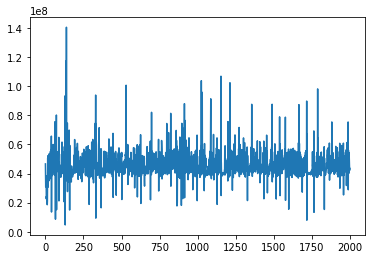

In [237]:
plt.plot(losses)

In [242]:
tgt

tensor([[48085.,  1035.,   319.],
        [42104.,   571.,   179.],
        [35056.,   445.,   476.],
        [44091.,  1324.,   527.]])

In [241]:
out.long()

tensor([[48231,   925,   859],
        [48591,   897,   861],
        [48278,   922,   859],
        [48591,   897,   861]])

In [ ]:
points = []
for i in range(100):
    src = torch.cat((src[2:], out.long()[0:2]), dim = 0)
    tgt_input = out
    out = t(src, torch.tensor(tgt_input))
    points.append(out[2])

In [ ]:
pointslong = []
for point in points:
    pointslong.append(point.long().numpy()[0]) 

In [ ]:
plt.plot(pointslong[0:50])

In [234]:
pointslong

[48591,
 48591,
 48591,
 48591,
 48567,
 48567,
 48591,
 48941,
 49008,
 48591,
 48591,
 48680,
 48591,
 48673,
 48591,
 48591,
 48591,
 48677,
 49007,
 48591,
 48861,
 48632,
 48591,
 48856,
 48632,
 48591,
 48591,
 48591,
 48591,
 48608,
 48749,
 48729,
 48290,
 48598,
 48446,
 48596,
 48856,
 48591,
 48116,
 48591,
 48567,
 48278,
 48591,
 48709,
 48747,
 49325,
 48446,
 48673,
 48591,
 48591,
 48591,
 48591,
 48591,
 48787,
 48461,
 48591,
 48729,
 48591,
 48861,
 48591,
 48591,
 48591,
 48855,
 48591,
 48591,
 48591,
 48591,
 48591,
 48591,
 48591,
 48725,
 48278,
 48591,
 48680,
 48591,
 48672,
 48705,
 48672,
 48591,
 48608,
 48591,
 48591,
 48591,
 48446,
 48608,
 48591,
 48591,
 48591,
 48281,
 48591,
 48591,
 48993,
 48649,
 49008,
 48729,
 49549,
 48823,
 48729,
 48591,
 48591]

In [ ]:
loss.item()

In [ ]:
m = trg.float().mean(0, keepdim=True)
s = trg.float().std(0, unbiased=False, keepdim=True)
trg = trg.float()
trg -= m
trg /= s

In [16]:
trg

tensor([1, 0, 0])

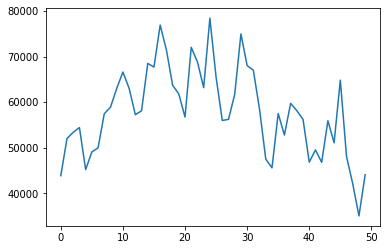

In [247]:
plt.plot(new_cases_usa[108:158])

In [113]:
losslist = []
for loss in losses:
    if loss.detach().numpy()/100000000 < 1:
        losslist.append(loss.detach().numpy()/100000000)

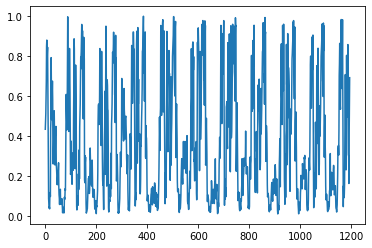

In [114]:
plt.plot(losslist)

In [236]:
losslist

[0.43421984,
 0.46710252,
 0.51242132,
 0.58849552,
 0.67432128,
 0.85082744,
 0.88062408,
 0.7656752,
 0.8177016,
 0.84469824,
 0.693038,
 0.4823476,
 0.27699402,
 0.08666919,
 0.06511165,
 0.03981423,
 0.045361855,
 0.0356375575,
 0.1046774,
 0.11715699,
 0.09766923,
 0.43788088,
 0.47677308,
 0.79283168,
 0.649179,
 0.48238504,
 0.6471448,
 0.6126022,
 0.67522536,
 0.58243936,
 0.31260348,
 0.26018014,
 0.28835944,
 0.37742512,
 0.48025888,
 0.52655668,
 0.39691656,
 0.3117248,
 0.25536664,
 0.3199621,
 0.44162228,
 0.4052652,
 0.448455,
 0.2584952,
 0.24019202,
 0.2132713,
 0.1591382,
 0.15639921,
 0.18273112,
 0.21358372,
 0.22699534,
 0.22790542,
 0.26627004,
 0.14819416,
 0.10607814,
 0.09010118,
 0.057476915,
 0.09196169,
 0.074525815,
 0.13385176,
 0.07620404,
 0.062236405,
 0.05840059,
 0.06028054,
 0.0676853,
 0.08661947,
 0.06814044,
 0.04424399,
 0.01584977875,
 0.0443707,
 0.041774305,
 0.01993646875,
 0.034140975,
 0.01497865375,
 0.02329014,
 0.09412473,
 0.082686275,
 

In [41]:
out.long()

tensor([[62601,   798,     4,   171],
        [67422,   880,     5,   172],
        [63238,   806,     4,   173],
        [68186,   889,     5,   174]])